<a href="https://colab.research.google.com/github/CianOSull/AutoML_With_SA_FYP_2021/blob/TPOT/MainNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generic Notebook for running all the libraries

How this notebook works is that it contains the code
for loading and cleaning the dataset.

Then there is multiple branches created on the
Github that include the code for running each library.

E.g. MLBox branch has the code for running MLBox.

# CURRENT BRANCH: TPOT

# Install TPOT

In [1]:
# Insert any install comamnds in this cell
!pip install deap update_checker tqdm stopit xgboost
!pip install tpot

     |████████████████████████████████| 163kB 5.7MB/s 
  Created wheel for stopit: filename=stopit-1.1.2-cp37-none-any.whl size=11954 sha256=9fe3219c59548dce98b5bd76975afdbd0f2286ca8dff4ae6f0356495357d33b3
  Stored in directory: /root/.cache/pip/wheels/3c/85/2b/2580190404636bfc63e8de3dff629c03bb795021e1983a6cc7
Successfully built stopit
     |████████████████████████████████| 92kB 3.8MB/s 
     |████████████████████████████████| 157.5MB 80kB/s 
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


# Preprocessing Section

In [2]:
# Import the necessary modules for cleaning
import math
import time 
import pandas as pd
import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize 
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [3]:
# Create the set of stopwords for cleaning text
stopwords = set(w.rstrip() for w in open('/content/drive/MyDrive/CIT/FYP/ImplementationFiles/stopwords.txt'))

In [4]:
# Download the necessary parts for the NLTK module
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [5]:
# This funciton handles celaning text
def clean_text(text):
    # Create the lemmatizer
    wordnet_lemmatizer = WordNetLemmatizer()
    
    # Get rid of non alpha characters except "'" as it is needed for the lemment
    text = "".join(c for c in text if c.isalnum() or c == " " or "'")
    
    # Get rid of capitals
    text = text.lower()
    
    # Tokenize the words    
    # Create tokens of each word
    token_text = word_tokenize(text)
    
    # Get rid of any piece of text that isn't over 2 characters
    token_text = [t for t in token_text if len(t) > 2] 
    
    # Put words in base form by doing lemmatization
    token_text = [wordnet_lemmatizer.lemmatize(t) for t in token_text]

    # Remove stopwords
    token_text = [t for t in token_text if t not in stopwords]
    
    # Return the tokens
    return token_text

In [6]:
# This function will get the term frequencies for word in the review
# TF = Term I frequency in document/total words in document
def calc_tf(term_count, review_corpus):
    # A dictionary of all the term frequencies found
    tf_freq = dict.fromkeys(term_count.keys(), 0)   
    
    # Review corpus is a tokenized list so the total words iteh length
    total_words = len(review_corpus)
    
    # Calculate the term frequency for each word
    for word, count in term_count.items():
        tf_freq[word] = count/total_words
        
    return tf_freq

In [7]:
# This calcualtes the idf
# IDF = log(2)*(Total number of Documents/documents frequency or documents with term)
def calc_idf(unique_terms, list_doc_terms):   
    # A dicitonary of all the inverse document frequencies
    idf = dict.fromkeys(unique_terms, 0)
    
    # Basically list_doc_terms has all the documents with the term count for each word
    # You go through each document count the terms where they occured
    for doc_terms in list_doc_terms:  
        # This for loop is counting the amount of document a word was in
        for word, value in doc_terms.items():
            if 0 < value:
                idf[word] += 1
        
    # Now we calculate idf
    for word, value in idf.items():
        idf[word] = math.log10(10 / float(value))
    
    return idf

In [8]:
# Modified this function to return a list as dictionaries arn't needed anymore
def calc_tf_idf(tf, idf, n_terms):
    # Create an array that is of length of the number of unique terms
    tf_idf_array = np.zeros(n_terms)
    
    for index, (word, value) in enumerate(tf.items()):
        # Add the tfidf to the array
        tf_idf_array[index] = value*idf[word]
    
    return tf_idf_array

In [9]:
def process_text(text_data):
    # A list of all the cleaned reviews
    doc_list = []
    
    # List of all the unique terms
    unique_terms = []
    
    # A list of all the term frequencies
    tf_list = []
    
    for review in text_data:
        # First clean the review
        clean_review = clean_text(review)
        
        # Keeps track of the term counts for each word
        count_dict = {}
        
        # Now lets find the total count for each word
        for token in clean_review:
            if token not in count_dict:
                count_dict[token] = 1
            else:
                count_dict[token] += 1
        
        # Caclulate the term frequencies for each document
        tf_list.append(calc_tf(count_dict, clean_review))
        
        # Then add the dictionary of counts for each document to the list
        doc_list.append(count_dict)
        
        # Then add the new unique terms
        unique_terms = set(unique_terms).union(set(clean_review))
    
    # Calculate the inverse document frequency value
    idf = calc_idf(unique_terms, doc_list)
    
    # This array will contain the tfidf values for each term in each review
    tfidf_values = np.zeros((len(tf_list), len(unique_terms)))
    
    # Now we can get the TFIDF for each document
    for index, term_freq in enumerate(tf_list):
        # This will return an array of the tfidf values calculated.
        # The length of the unique terms list is passed in so that the 
        # Array that is returned matches the tfidf array
        tf_idf_array = calc_tf_idf(term_freq, idf, len(unique_terms))
        # Add this to the overall tfidf values calculated
        tfidf_values[index,:] = tf_idf_array
    
    return tfidf_values

In [10]:
# Prepare the data
def prepare_data(num):
    print("="*50)

    # Load the dataset
    # imdb_df = pd.read_csv("IMDB Dataset.csv")
    imdb_df = pd.read_csv("/content/drive/MyDrive/CIT/FYP/ImplementationFiles/IMDB_Dataset.csv")
    print("Dataset loaded")
    print("="*50)
    
     # Change each positive and negative value to 1 and 0 respectively    
    imdb_df['sentiment'] = imdb_df['sentiment'].map({'negative' : 0, 'positive' : 1})
    
    # For testing, a much smaller dataset is going to be used
    # imdb_df = imdb_df.head(25000)

    # Group all the negative reviews and get the first 2500
    imdb_df_neg = (imdb_df[imdb_df['sentiment'] == 0])[0:num]
    # Group all the positive and get the first 2500
    imdb_df_pos = imdb_df[imdb_df['sentiment'] == 1][0:num]
    
    # Combine the two split positives and negatives into one dataframe
    imdb_df = pd.concat([imdb_df_neg, imdb_df_pos]) 
    # print(test_df)
    
    # .values on a column of a dataframe returns a numpy array
    # This is a numpy array of all the reviews
    # initial_reviews = imdb_df['review'].values
    initial_reviews = imdb_df['review'].values
    
    # This is a numpy array of all the positive and negativelabels
    # labels = imdb_df['sentiment'].values
    labels = imdb_df['sentiment'].values
    
    print("Creating Feature Vector")
    print("="*50)
    start = time.time()
    # Process the text data and create teh feature vector
    feature_vector = process_text(initial_reviews)
    end = time.time()
    print("Feature Vector Created")
    print(f"Execution time is {end - start} secs")
    print("="*50)
    
    # Shuffle the labesl and feature vector using sklearn shuffle
    feature_vector, labels = shuffle(feature_vector, labels)
    
    # Creating train and test data
    # The splits will be 80:20 
    no_samples = 0.8
    
    # This gets the percentage of indexes from feature vector and uses those for training
    X_train = feature_vector[0:int(no_samples*len(feature_vector))]
    y_train = labels[0:int(no_samples*len(labels))]
    
    # Go from the index that was used for training to the final
    X_test = feature_vector[int(no_samples*len(feature_vector)):len(feature_vector)]
    y_test = labels[int(no_samples*len(labels)):len(labels)]

    return X_train, y_train, X_test, y_test

# Run the automl

http://epistasislab.github.io/tpot/using/#tpot-with-code

In [11]:
X_train, y_train, X_test, y_test = prepare_data(500)
print(len(X_train))

Dataset loaded
Creating Feature Vector
Feature Vector Created
Execution time is 5.267710447311401 secs
800


In [12]:
# Insert the code for running the libraries in here
from tpot import TPOTClassifier

pipeline_optimizer = TPOTClassifier()

# This is the example classifier used
pipeline_optimizer = TPOTClassifier(generations=1, population_size=5, cv=5,
                                  random_state=42, verbosity=2)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [13]:
print("Creating Model")
print("="*50)
start = time.time()
try:
  pipeline_optimizer.fit(X_train, y_train)
except Exception as e:
  print(e)
end = time.time()
print("Model Created")
print(f"Execution time is {end - start} secs")
print("="*50)

Creating Model



Generation 1 - Current best internal CV score: 0.52125

Best pipeline: GaussianNB(input_matrix)
Model Created
Execution time is 953.455694437027 secs


In [ ]:
print("Evaluating Model")
print("="*50)
start = time.time()
print(pipeline_optimizer.score(X_test, y_test))
end = time.time()
print("Evaluating done")
print(f"Execution time is {end - start} secs")
print("="*50)

Evaluating Model
0.51
Evaluating done
Execution time is 0.08102893829345703 secs


In [ ]:
# Naming convention is tpot_time_pop
print("Exporting Model")
print("="*50)
# Format is tpot_generations_populatiopn_datasize
pipeline_optimizer.export('/content/drive/MyDrive/CIT/FYP/ImplementationFiles/ExportedModels/TPOT/tpot_1_5_5000.py')
print("Model Exported")

Exporting Model
Model Exported


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

# Modified to load our data
X_train, y_train, X_test, y_test = prepare_data(500)

# Average CV score on the training set was: 0.503
exported_pipeline = GaussianNB()
# Fix random state in exported estimator
if hasattr(exported_pipeline, 'random_state'):
    setattr(exported_pipeline, 'random_state', 42)

exported_pipeline.fit(X_train, y_train)
results = exported_pipeline.predict(X_test)

Dataset loaded
Creating Feature Vector
Feature Vector Created
Execution time is 4.23347806930542 secs


In [ ]:
print(accuracy_score(y_test, results))

0.485


# Metrics

In [ ]:
from sklearn import metrics

# paramters are y_true, y_pred
C = metrics.confusion_matrix(y_test, results)

# lists for the confusion matrix
true_positive = []
true_negative = []
false_postiive = []
false_negatives = []

true_positive.append(C[0,0])
true_negative.append(C[1,1])            
false_postiive.append(C[1,0])
false_negatives.append(C[0,1])

print(C)

print(("="*50))

print("True positives:", round(np.sum(true_positive)/len(y_test), 5), "%")
print("True negatives:", round(np.sum(true_negative)/len(y_test), 5), "%")
print("False positives:", round(np.sum(false_postiive)/len(y_test), 5), "%")
print("False negatives:", round(np.sum(false_negatives)/len(y_test), 5), "%")

[[89  6]
 [97  8]]
True positives: 0.445 %
True negatives: 0.04 %
False positives: 0.485 %
False negatives: 0.03 %


In [ ]:
true_positive = C[0,0]
true_negative = C[1,1]            
false_postiive = C[1,0]
false_negatives = C[0,1]

precision = true_positive/(true_positive+false_postiive)
recall = true_positive/(true_positive/false_negatives)

In [ ]:
f1_score = (precision*recall)/(precision+recall)

print(f1_score)

0.4431535269709544


In [ ]:
fpr, tpr, thresh = metrics.roc_curve(y_test, results)

auc = metrics.auc(fpr, tpr)

print("AUC:", auc)

AUC: 0.506516290726817


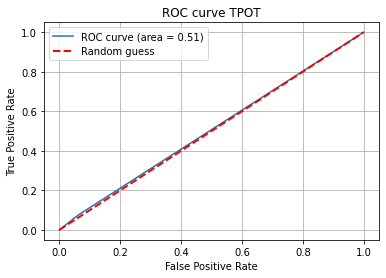

In [ ]:
import matplotlib.pyplot as plt

plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' %auc)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.title('ROC curve TPOT')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

# Test dataset

In [ ]:
# Load the dataset
imdb_df = pd.read_csv("/content/drive/MyDrive/CIT/FYP/ImplementationFiles/NPS_TestContent.csv", encoding='utf8', engine='c')
# imdb_df = pd.read_excel("/content/drive/MyDrive/CIT/FYP/ImplementationFiles/NPS_TestContent.xlsx")

imdb_df['sentiment'] = imdb_df['sentiment'].map({'Negative' : 0, 'Positive' : 1})

# Group all the negative reviews and get the first 25000
# imdb_df_neg = (imdb_df[imdb_df['sentiment'] == "negative"])[0:2500]
imdb_df_neg = (imdb_df[imdb_df['sentiment'] == 0])
# Group all the positive and get the first 25000
# imdb_df_pos = imdb_df[imdb_df['sentiment'] == "positive"][0:2500]
imdb_df_pos = imdb_df[imdb_df['sentiment'] == 1]

# Combine the two split positives and negatives into one dataframe
imdb_df = pd.concat([imdb_df_neg, imdb_df_pos]) 

# .values on a column of a dataframe returns a numpy array
# This is a numpy array of all the reviews
initial_reviews = imdb_df['test'].values
print("Creating Feature Vector")
print("="*50)
start = time.time()
# Process the text data and create teh feature vector
feature_vector = process_text(initial_reviews)
end = time.time()
print("Feature Vector Created")
print(f"Execution time is {end - start} secs")
print("="*50)
# print(feature_vector)

# This is a numpy array of all the positive and negativelabels
labels = imdb_df['sentiment'].values

# Shuffle the labesl and feature vector using sklearn shuffle
feature_vector, labels = shuffle(feature_vector, labels)

# Creating train and test data
# The splits will be 80:20 
no_samples = 0.8

# This gets the percentage of indexes from feature vector and uses those for training
X_train = feature_vector[0:int(no_samples*len(feature_vector))]
y_train = labels[0:int(no_samples*len(labels))]

# Go from the index that was used for training to the final
X_test = feature_vector[int(no_samples*len(feature_vector)):len(feature_vector)]
y_test = labels[int(no_samples*len(labels)):len(labels)]

print(X_train.shape)
print(type(X_train))

Creating Feature Vector
Feature Vector Created
Execution time is 0.46523618698120117 secs
(1198, 1703)
<class 'numpy.ndarray'>


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

# Average CV score on the training set was: 0.503
exported_pipeline = GaussianNB()
# Fix random state in exported estimator
if hasattr(exported_pipeline, 'random_state'):
    setattr(exported_pipeline, 'random_state', 42)

exported_pipeline.fit(X_train, y_train)
results = exported_pipeline.predict(X_test)

In [ ]:
print(accuracy_score(y_test, results))

0.79
